# Matrix Factorization with NN

https://arxiv.org/abs/1511.06443

In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import numpy as np
import tensorflow as tf
import random

# Dev

In [3]:
R_    = np.array([[1,3,3,4,5],
                  [1,2,4,3,5],
                  [5,3,2,5,1]])
mask_ = np.array([[1,1,1,1,1],
                  [1,0,0,0,0],
                  [1,1,1,1,1]])

n_users, n_items = R_.shape
latent_dim = 2
latent_dim_p = 2 # the D' in the paper

reg_rate = 1.
learning_rate = 0.01
hidden_units = 5

# Inputs
R = tf.placeholder(tf.float32, name="R")
# This is hacky: I pass in a list of indices of elements to want to train on, call this a "batch".
idx_i = tf.placeholder(tf.int32, name="idx_i")
idx_j = tf.placeholder(tf.int32, name="idx_j")
batch_size = tf.placeholder(tf.int32, name="batch_size") # TODO infer from idx_i

with tf.variable_scope("Latents"):
    U = tf.Variable(tf.random_uniform([n_users, latent_dim], -1.0, 1.0), name='user_matrix')
    V = tf.Variable(tf.random_uniform([n_items, latent_dim], -1.0, 1.0), name='item_matrix')
    # (*1) TODO I'm implicitly keeping K=1 for now, just like the paper.
    # So each latent matrix is actually just a latent vector---the rows of the following matrices.
    Up = tf.Variable(tf.random_uniform([n_users, latent_dim_p], -1.0, 1.0), name='user_matrix_p')
    Vp = tf.Variable(tf.random_uniform([n_items, latent_dim_p], -1.0, 1.0), name='item_matrix_p')

# U,V,U',V'
U_vector = tf.gather(U, idx_i)
V_vector = tf.gather(V, idx_j)
U_mat = tf.gather(Up, idx_i) # TODO gathering vectors, not actual matrices - see (*1)
V_mat = tf.gather(Vp, idx_j)
#UV_interaction = tf.reduce_sum(tf.multiply(U_mat, V_mat), 0) # Use this if we have matrices - see (*1)
UV_interaction = tf.multiply(U_mat, V_mat)
all_latent_vars = tf.reshape(tf.concat([U_vector, V_vector, UV_interaction], axis=1),
                             [batch_size, latent_dim*2+latent_dim_p])

# NN
with tf.variable_scope("NeuralNet"):
    layer_1 = tf.layers.dense(inputs=all_latent_vars, units=hidden_units, activation=tf.nn.relu)
    layer_out = tf.layers.dense(inputs=layer_1, units=1, activation=None) # None for Linear activation

# Loss
target = tf.reshape(tf.gather_nd(R, tf.transpose(tf.stack([idx_i, idx_j]))), [batch_size,1])
error = tf.square(layer_out - target)
reg = tf.norm(U) + tf.norm(V) + tf.norm(Up) + tf.norm(Vp)
loss = tf.reduce_sum(error) + reg_rate * reg

# Optimize
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
latents_vars_ = [v for v in tf.trainable_variables() if v.name.startswith('Latents')]
latents_optim = optimizer.minimize(loss, var_list=latents_vars_)
nn_vars_ = [v for v in tf.trainable_variables() if v.name.startswith('NeuralNet')]
nn_optim = optimizer.minimize(loss, var_list=nn_vars_)
training_steps = [nn_optim, latents_optim]

initialize = tf.global_variables_initializer()

In [4]:
# Inspect trainable_variables; note some start with "Latents" and some start with "NeuralNet"
tf.trainable_variables()

[<tf.Variable 'Latents/user_matrix:0' shape=(3, 2) dtype=float32_ref>,
 <tf.Variable 'Latents/item_matrix:0' shape=(5, 2) dtype=float32_ref>,
 <tf.Variable 'Latents/user_matrix_p:0' shape=(3, 2) dtype=float32_ref>,
 <tf.Variable 'Latents/item_matrix_p:0' shape=(5, 2) dtype=float32_ref>,
 <tf.Variable 'NeuralNet/dense/kernel:0' shape=(6, 5) dtype=float32_ref>,
 <tf.Variable 'NeuralNet/dense/bias:0' shape=(5,) dtype=float32_ref>,
 <tf.Variable 'NeuralNet/dense_1/kernel:0' shape=(5, 1) dtype=float32_ref>,
 <tf.Variable 'NeuralNet/dense_1/bias:0' shape=(1,) dtype=float32_ref>]

In [5]:
# # Check your work.
# with tf.Session() as sess:
#     sess.run(initialize)
#     feed_dict = {
#         R: R_,
#         idx_i: [0,0,1,1,1],
#         idx_j: [0,0,0,1,2],
#         batch_size: 5
#     }
#     print(sess.run(error, feed_dict))

# Training

iteration 0 - loss 29.573348999023438
iteration 50 - loss 5.676641464233398
iteration 100 - loss 4.0773749351501465
iteration 150 - loss 3.0371932983398438
iteration 200 - loss 2.385239601135254
iteration 250 - loss 2.0076894760131836
iteration 300 - loss 1.7851357460021973
iteration 350 - loss 1.7240792512893677
iteration 400 - loss 1.571164608001709
iteration 450 - loss 2.1623947620391846
Original:
[[1 3 3 4 5]
 [1 2 4 3 5]
 [5 3 2 5 1]]
Reconstruction:
[[ 1.32281065  3.32777548  3.20241785  3.75711298  4.7683568 ]
 [ 1.42005157  3.00148511  2.64149547  3.47207546  3.91867447]
 [ 5.5892477   3.56239867  1.15946281  4.39220858  0.35526472]]


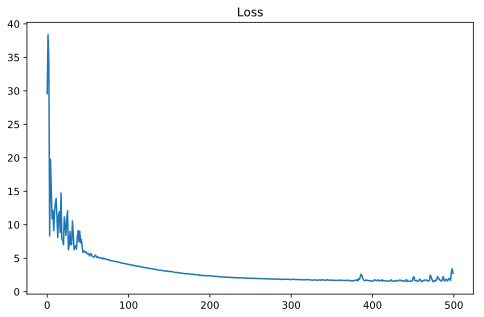

In [6]:
# Train
seen_indices = np.array(np.where(mask_))
losses = []
BATCH_SIZE = 5
with tf.Session() as sess:
    sess.run(initialize)
    
    for i in range(500):
        # Train on a batch of BATCH_SIZE random elements each iteration.
        rand_idx = np.random.choice(seen_indices.shape[1], BATCH_SIZE, replace=False)
        feed_dict = {
            R: R_,
            idx_i: seen_indices[0, rand_idx],
            idx_j: seen_indices[1, rand_idx],
            batch_size: BATCH_SIZE
        }
        for step in training_steps:
            sess.run(step, feed_dict)
        losses.append(sess.run(loss, feed_dict))
        if i % 50 == 0: print("iteration {} - loss {}".format(i, losses[-1]))
    
    # Look at final reconstruction.
    feed_dict = {
        R: R_,
        idx_i: np.where(np.ones(R_.shape))[0],
        idx_j: np.where(np.ones(R_.shape))[1],
        batch_size: R_.shape[0] * R_.shape[1]
    }
    reconstruction = sess.run(layer_out, feed_dict)
    print("Original:")
    print(R_)
    print("Reconstruction:")
    print(reconstruction.reshape(R_.shape))
    
plt.plot(losses)
plt.title("Loss")